# Computing a PCA of tile-level CHARM features

This notebook examplifies working with the computed CHARM features. 

We will load several well worth of time resolved tile-level features, compute their PCA, and show that single cell biologicaly relevant information are indeed present in unsupervised features comupted on tiles without segementation.

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shelve
import random
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf
#rom omero.gateway import BlitzGateway
import omero
from matplotlib.widgets import Slider
from matplotlib import gridspec
from sklearn.externals import joblib


from sklearn import random_projection
import sklearn.neighbors as nn
import sklearn.manifold as man
import sklearn.decomposition as dec
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics.pairwise import euclidean_distances

from idr_demo import connection
import tables

%matplotlib inline
plt.rcParams['image.cmap']='gray'


In [2]:
def getBulkAnnotationAsDf(screenID,conn):
#    ofId=8118685
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn

In [3]:
def imshowStack(st):
    z0=st.shape[2]/2
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplots_adjust(left=0.25, bottom=0.15)
    if len(st.shape)==4:
        imobj=plt.imshow(st[:,:,z0,:])
    else:
        imobj=plt.imshow(st[:,:,z0])
        
    axcolor = 'lightgoldenrodyellow'
    axz = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
    sz = Slider(axz, 'z', 0, st.shape[2], valinit=z0)
    def update(val):
        z = sz.val
        if len(st.shape)==4:
            imobj.set_data(st[:,:,z,:])
        else:
            imobj.set_data(st[:,:,z])
        fig.canvas.draw_idle()
    sz.on_changed(update)

    return sz

In [4]:
def goneFishing(pln,x,y,t,df,nbrs):
#    pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220

    qry=df[(df.x==x) & (df.y==y) & (df.name==pln) & (df.t==t)].iloc[:,12:]

    dfq=df[df.name!=pln]
    w=dfq.w.iloc[0]
    h=dfq.h.iloc[0]
    chan=0
    
    spl=pln.split('_')
    plateName,wellNb=spl[0]+'_'+spl[1]+'_'+spl[2],int(spl[3])

    hook=getCondensationSubStack(wellNb,x,y,w,h,t,t+1,chan, plateName=plateName)    
    
    distances, indices = nbrs.kneighbors(qry)
    nnn=len(indices[0])
    tiles=np.zeros((h,w,nnn))
    for ind,ii in zip(indices[0],range(nnn)):
        wellNb=dfq.series.iloc[ind]
        x=dfq.x.iloc[ind]
        y=dfq.y.iloc[ind]
        t=dfq.t.iloc[ind]
        plateName=dfq['name'].iloc[ind]
        spl=plateName.split('_')
        plateName=spl[0]+'_'+spl[1]+'_'+spl[2]
        tiles[:,:,ii]=getCondensationSubStack(wellNb,x,y,w,h,t,t+1,chan, plateName=plateName) 

    
    d,r=divmod(nnn,4)
    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0,0])
#    ax0.set_title(title)
    ax0.imshow(hook)

    imc=buildComposite(tiles,d+(1&r),4,smpl=1)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.imshow(imc)
    

In [83]:
def getCondensationSubStack(imId,x,y,w,h,ti,tf,conn,chan=0):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150

    im = conn.getObject("Image", imid)
    pix=im.getPrimaryPixels()

    z=0;c=chan;
    tile = (x, y, w, h) 
    zctList = [(z, c, it, tile) for it in range(ti,tf)]
    planes = pix.getTiles(zctList)
    st=[]
    for plane in planes:
        st.append(plane)

    st=np.asarray(st)
    if tf>ti+1:
        st=np.rollaxis(st,0,3)
    else:
        st=np.squeeze(st)
    
    return st

In [6]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [7]:
#should be useless now, remove?

def getImIDs(plns, wellNbs):
    lids=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for pln,wn in zip(plns,wellNbs):
            r,c=divmod(wn,12)
            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.name = \'''' + pln+ '\' and well.row='+str(r)+' and well.column='+str(c)

            im = conn.getQueryService().findAllByQuery(Q,None)[0].getPrimaryWellSample().getImage()
            lids.append(im.getId().getValue())
    finally:
        conn._closeSession()
    
    return lids

In [8]:
def getMapAnnotationsAsDicts(imids):
    la=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for imid in imids:
            im= conn.getObject("Image",imid)
            a=im.getAnnotation()
            la.append(dict(a.getValue()))
    finally:
        conn._closeSession()
    
    return la


In [88]:
def outOneStack(imId,x,y, df, con,alg='PCA',chan=0,title=''):
#    pln='plate1_1_013_5'
#    x=504
#    y=384

    df=df[(df.x==x) & (df.y==y) & (df.ImageID==imId)].sort_values('t',ascending=True)

    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
    ax0 = plt.subplot(gs[0,0])
    ax0.set_title(title)
    if alg=='PCA':
        ax0.plot(df.PCA_0.values)
        ax0.plot(df.PCA_1.values,'r')
        ax0.plot(df.PCA_2.values,'g')
        ax0.plot(df.PCA_3.values,'y')
        ax0.plot(df.PCA_4.values,'m')
        ax0.plot(df.PCA_5.values,'c')
    elif alg=='DR':
        ax0.plot(df.DR_0.values)
        ax0.plot(df.DR_1.values,'r')
        ax0.plot(df.DR_2.values,'g')
        ax0.plot(df.DR_3.values,'y')
        ax0.plot(df.DR_4.values,'m')


    x,y,w,h=x,y,df.w.min(),df.h.min()
    #plateId,wellNb,x,y,w,h=492,5,dfst.x.min(),dfst.y.min(),dfst.w.min(),dfst.h.min()
    ti,tf=df.t.min(),df.t.max()
    st=getCondensationSubStack(imId,x,y,w,h,ti,tf, conn,chan)    
    
    imc=buildComposite(st,5,5)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.imshow(imc)
    return st

## Loading Data

In [94]:
conn = connection()

In [63]:
#df=read_hdf('/uod/idr/features/idr0002-heriche-condensation/screenA/tables/test_set.h5',key='/OME/Measurements')



In [65]:
scId=102 #Heriche et al., DNA condentation screen

#get annotations
dfAnn=getBulkAnnotationAsDf(scId,conn)

In [ ]:
#loading the feature table 
#TODO when it can be accessed through the api

sc=conn.getObject('Screen',scId)
#printing names of all files attached to the screen
for ann in sc.listAnnotations():
    if isinstance(ann, omero.gateway.FileAnnotationWrapper):
        print ann.getFile().getName()

#getting the fileAnnotation correponding to the features
#!!! not the full file
for ann in sc.listAnnotations():
    if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()==' '):
            ofId=ann.getFile().getId()
            break
            
original_file = omero.model.OriginalFileI(ofId, False)

featTable = conn.c.sf.sharedResources().openTable(original_file)
featRowCount = featTable.getNumberOfRows()
print featRowCount


In [17]:
#loading the .h5

h5t = tables.open_file("/uod/idr/features/idr0002-heriche-condensation/screenA/tables/plate1_1_013.h5", "r")
ta=h5t.root.OME.Measurements

In [100]:
#loading the features correponding to 4 images
#(takes about 50min)

res = [ta.read_where("ImageID==%s" % i ) for i in [179727, 179741, 179712, 179728]]


In [101]:
#loading them nicely in a dataframe
#(takes a while, and 10Gb)

df=DataFrame()
for iim in range(4):
    print iim
    x=res[iim]
    header_meta = []
    header_ft = []
    header_ftn = []
    # width_ft = []

    for i,t in enumerate(x.dtype.names):
        if (hasattr(x[0][i], "__len__") and (not isinstance(x[0][i], str))):
            header_ft.append(t)
            header_ftn.extend('%s_%02d' % (t, i) for i in xrange(len(x[0][i])))
        else:
            header_meta.append(t)


    rows = []
    for irow in range(len(x)):
        r=x[irow]
        l=[]
        for i in r:
            if (hasattr(i, "__len__") and (not isinstance(i, str))):
                l.extend(i)        
            else:
                l.append(i)

        rows.append(list(l))

    #    print "Creating dataframe %s" % fin
    df = concat((df,DataFrame(rows, columns=(header_meta + header_ftn))))


0
1
2
3


In [59]:
df.columns[10:]

Index([u'chebyshev_coefficients_00', u'PCA_0', u'PCA_1', u'PCA_2', u'PCA_3',
       u'PCA_4', u'PCA_5', u'PCA_6', u'PCA_7', u'PCA_8',
       ...
       u'PCA_240', u'PCA_241', u'PCA_242', u'PCA_243', u'PCA_244', u'PCA_245',
       u'PCA_246', u'PCA_247', u'PCA_248', u'PCA_249'],
      dtype='object', length=251)

## computing PCA

In [ ]:
#PCA of 4 wells
    
df=df[df.c==0]
dat=df.iloc[:,10:]
#keeping only the features which are not too discrete
#nbv=[len(dat[x].unique()) for x in df.iloc[:,12:]]
#dat=dat.iloc[:,np.array(nbv)>10]

dat=scale(dat)


pca=dec.PCA(n_components=250,svd_solver='randomized')
#pca=dec.RandomizedPCA(250)
#pca=dec.SparsePCA(250)
#pca=dec.KernelPCA(n_components=10,kernel='rbf')

pca.fit(dat)
datPCA=pca.transform(dat)
datPCA=DataFrame(datPCA)
datPCA.columns=['PCA_'+str(i) for i in range(datPCA.shape[1])]
df=df.reset_index(drop=True)
df=concat((df.iloc[:,0:10],datPCA),axis=1)
#transformer = random_projection.SparseRandomProjection(n_components=500)
#dat = transformer.fit_transform(dat)


In [ ]:
#projecting all other wells

#TODO

_, _, filenames = next(os.walk(h5path), (None, None, []))
for f in filenames[:-4]:
    dfcur=DataFrame()
    f=os.path.join(h5path,f)
    dfcur=read_hdf(f)
    dfcur=dfcur[dfcur.c==0]
    dat=dfcur.iloc[:,11:]
    dat=scale(dat)
    datPCA=pca.transform(dat)
    datPCA=DataFrame(datPCA)
    datPCA.columns=['PCA_'+str(i) for i in range(datPCA.shape[1])]
    dfcur=dfcur.reset_index(drop=True)
    dfcur=concat((dfcur.iloc[:,0:11],datPCA),axis=1)
    df=concat((df,dfcur))
df=df.reset_index(drop=True)

In [ ]:
## adding all anotations, ie gene name

#todo

def name2plateName(pln):
    spl=pln.split('_')
    return spl[0]+'_'+spl[1]+'_'+spl[2]



dfw=df[['name','series']].drop_duplicates()

dfw['plateName']=[name2plateName(s) for s in dfw['name']]

dfw['ID']=getImIDs(dfw['plateName'], dfw['series'])

dfw['Annotations']=getMapAnnotationsAsDicts(dfw['ID'])

l=list()
for i,row in df.iterrows():
    try:
        l.append(dfw[(dfw['name']==row['name'])&(dfw['series']==row['series'])]['Annotations'].iat[0]['Gene Symbol'])
    except:
        l.append('WT')
        
df.insert(0,'geneName',l)




In [ ]:
#todo

df.to_hdf(os.path.join('data','PCA250features_testwells.h5'),'PCAfeatures')

In [ ]:

#todo

joblib.dump(pca, os.path.join(dataDir,'PCA_4condentationwells.pkl') )

In [ ]:
#todo

pca= joblib.load(os.path.join(dataDir,'PCA_4condentationwells.pkl')) 
df=read_hdf(os.path.join(dataDir,'PCA250features_testwells.h5'))

## some display

In [73]:
dfAnn[dfAnn['Gene Symbol']=='CDK1'].Well

5       67079
101     93709
197    119064
293    142130
416    164816
512    182943
608    209785
704    235371
Name: Well, dtype: int64

In [78]:
df.WellID.unique().shape

(4,)

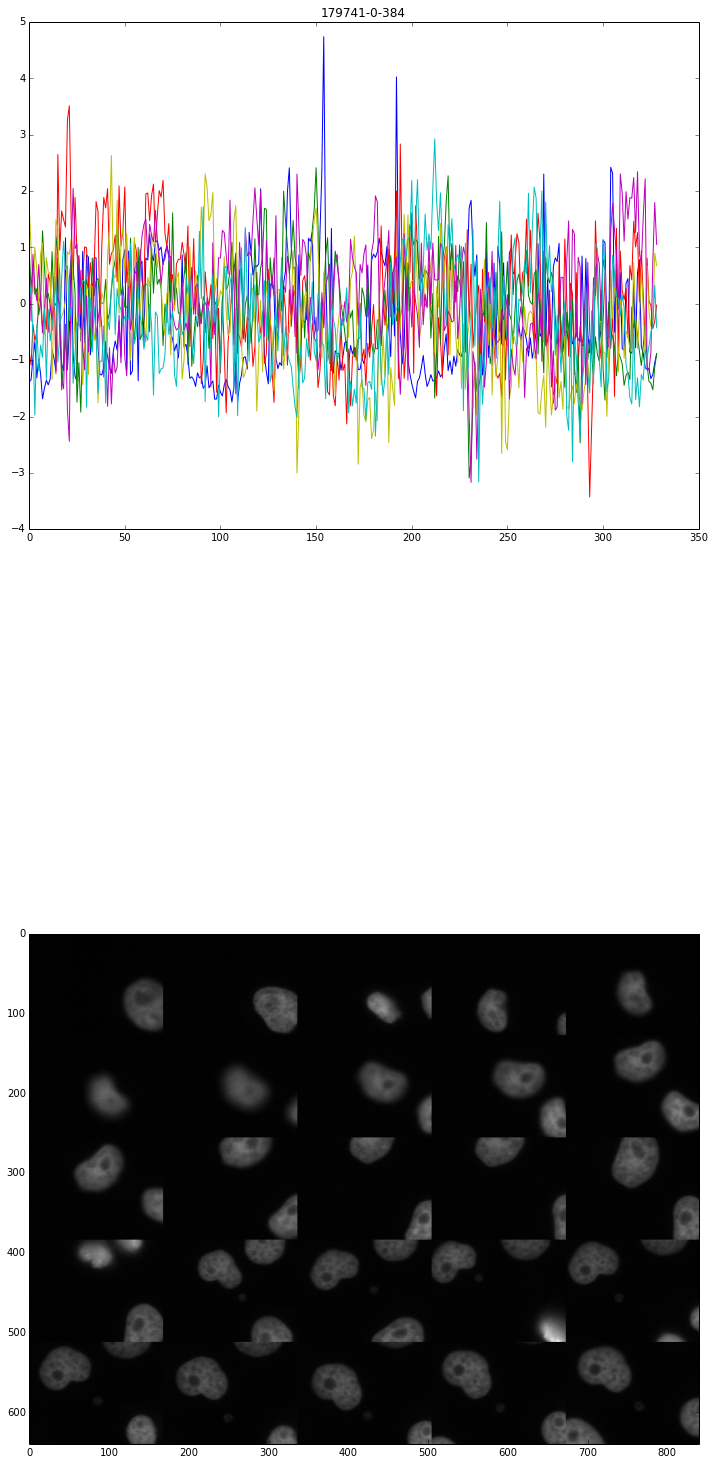

In [98]:
#one tile at random

#pln,x,y='plate1_1_013_5',504,384  #division at 220
#pln,x,y='plate2_5_015_24',672,128  #nothing

#at random
x=random.choice(df.x.unique())
y=random.choice(df.y.unique())
imId=random.choice(df['ImageID'].unique())

st=outOneStack(imId,x,y, df,conn,alg='PCA',chan=0,title=str(imId)+'-'+str(x)+'-'+str(y))

In [ ]:
imshowStack(st)

In [ ]:
## Going fishing for NN

pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220
#pln,x,y,t='plate1_2_006_5',168,896,66  #division at 30 and 66

#at random
#x=random.choice(df.x.unique())
#y=random.choice(df.y.unique())
#t=random.choice(range(df.t.max()))
#pln=random.choice(df['name'].unique())

dfq=df[df.name!=pln]
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfq.iloc[:,12:]) #was 11 before geneName got added


goneFishing(pln,x,y,t,df,nbrs)

## charm fishing

In [ ]:

_, _, filenames = next(os.walk(h5path), (None, None, []))
df=DataFrame()
for f in filenames[-4:]:
    f=os.path.join(h5path,f)
    df=concat((df,read_hdf(f)))

df=df[df.c==0]
df.iloc[:,12:]=scale(df.iloc[:,12:])


In [ ]:


pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220
#pln,x,y,t='plate1_2_006_5',168,896,66  #division at 30 and 66

#at random
#x=random.choice(df.x.unique())
#y=random.choice(df.y.unique())
#t=random.choice(range(df.t.max()))
#pln=random.choice(df['name'].unique())

dfq=df[df.name!=pln]
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfq.iloc[:,12:])


goneFishing(pln,x,y,t,df,nbrs)

## Stuff

In [24]:
print os.system("ls -l /data/OMERO/Files/Dir-008/Dir-069/")
import subprocess

#p = subprocess.Popen("ls -l /uod/idr/features/idr0002-heriche-condensation/screenA/tables/", shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
p = subprocess.Popen("free -h", shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
for line in iter(p.stdout.readline, ''): print line

512
             total       used       free     shared    buffers     cached

Mem:           31G        27G       4.2G        56M       1.7M        13G

-/+ buffers/cache:        13G        17G

Swap:           0B         0B         0B

